# 프로젝트 : 한국어 데이터로 챗봇 만들기

## STEP 1. 데이터 수집하기

In [1]:
import tensorflow as tf
import os
import re
import numpy as np
import matplotlib.pyplot as plt

In [2]:
file_path = os.path.dirname(os.path.abspath('__file__')) + r'/data/ChatbotData.csv'

In [3]:
import pandas as pd

df = pd.read_csv(file_path)
df.head(15)

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0
5,SD카드 망가졌어,다시 새로 사는 게 마음 편해요.,0
6,SD카드 안돼,다시 새로 사는 게 마음 편해요.,0
7,SNS 맞팔 왜 안하지ㅠㅠ,잘 모르고 있을 수도 있어요.,0
8,SNS 시간낭비인 거 아는데 매일 하는 중,시간을 정하고 해보세요.,0
9,SNS 시간낭비인데 자꾸 보게됨,시간을 정하고 해보세요.,0


In [20]:
print(df.shape)

(11823, 3)


## Step 2. 데이터 전처리하기

In [4]:
from konlpy.tag import Okt

okt = Okt()

In [19]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    
    tmp = okt.pos(sentence)
    res = ''
    
    for word, tp in tmp:
        if tp not in ['Noun', 'Adjective', 'Punctuation', 'Adverb', 'Verb']:
            continue
        else:
            res += word + " "
    
    return res[:-1]

In [18]:
preprocess_sentence("한글 자연어 처리는 크킄킄 재미있다. 열심히 해야지! . ")

'한글 자연어 처리 크킄킄 재미있다 . 열심히 해야지 ! .'

In [36]:
def load_conversations():
    inputs, outputs = [], []
    
    for data in df['Q']:
        inputs.append(preprocess_sentence(data))
    
    for data in df['A']:
        outputs.append(preprocess_sentence(data))
    
    return inputs, outputs

In [67]:
questions, answers = load_conversations()
print(len(questions), len(answers))

11823 11823


In [38]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

전처리 후의 22번째 질문 샘플: 가스 비 장난 아님
전처리 후의 22번째 답변 샘플: 다음 달 더 절약 해봐요 .


## Step 3. SubwordTextEncoder 사용하기

### toeknizer 만들기

In [41]:
# tokenizer 만들기
import tensorflow_datasets as tfds

tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size = 2**13)
print("슝=3")

슝=3


In [42]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [43]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [7182]
END_TOKEN의 번호 : [7183]


In [44]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

7184


### 각 단어를 고유한 정수로 인코딩 & 패딩

In [45]:
# 22번째 문장에 대해서 인코딩 & 패딩 테스트
print("정수 인코딩 후 21번째 질문 샘플 : {}".format(tokenizer.encode(questions[21])))
print("정수 인코딩 후 21번째 답변 샘플 : {}".format(tokenizer.encode(answers[21])))

정수 인코딩 후 21번째 질문 샘플 : [3905, 236, 883, 2956]
정수 인코딩 후 21번째 답변 샘플 : [329, 188, 16, 1800, 291, 1]


In [68]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이.
MAX_LENGTH = 50
print(MAX_LENGTH)

50


In [69]:
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        # 최대길이 40 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
        
        tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_inputs, maxlen = MAX_LENGTH, padding = 'post'
        )
        tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
            tokenized_outputs, maxlen = MAX_LENGTH, padding = 'post'
        )
        
        return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [70]:
tokenized_questions, tokenized_answers = tokenize_and_filter(questions, answers)
print("단어장의 크기 : ", VOCAB_SIZE)
print("필터링 후 샘플의 갯수 : ", len(questions))

단어장의 크기 :  7184
필터링 후 샘플의 갯수 :  11823


### 교사강요 사용하기

In [72]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 Input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs' : tokenized_questions,
        'dec_inputs' : tokenized_answers[:, :-1]
    },
    {
        'outputs' : tokenized_answers[:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


## Step 4. 모델 구성하기

### 필요한 함수들 정의

In [74]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
print("슝=3")

슝=3


In [75]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  """어텐션 가중치를 계산. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output
print("슝=3")

슝=3


In [76]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다.
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷-프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다.
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [77]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [78]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [79]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝♥")

슝♥


In [80]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [81]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [82]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


### 트랜스포머 함수 정의

In [84]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name='transformer'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    
    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, 
        output_shape = (1, 1, None),
        name = 'enc_padding_mask'
    )(inputs)
    
    # 디코더에서 미래의 토큰을 마스크하기 위해 사용
    # 내부적으로 패딩 마스크도 포함
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape = (1, None, None),
        name = 'look_ahead_mask'
    )(dec_inputs)
    
    # 두번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask,
        output_shape = (1, 1, None),
        name = 'dec_padding_mask'
    )(inputs)
    
    # 인코더
    enc_outputs = encoder(
        vocab_size = vocab_size,
        num_layers = num_layers,
        units = units,
        d_model = d_model,
        num_heads = num_heads,
        dropout = dropout
    )(inputs = [inputs, enc_padding_mask])
    
    # 디코더
    dec_outputs = decoder(
        vocab_size = vocab_size,
        num_layers = num_layers,
        units = units,
        d_model = d_model,
        num_heads = num_heads,
        dropout = dropout
    )(inputs = [dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])
    
    # 완전 연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name='outputs')(dec_outputs)
    
    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs = outputs, name = name)

print("슝=3")    

슝=3


### 모델 생성

In [85]:
tf.keras.backend.clear_session()

# 하이퍼 파라미터
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size = VOCAB_SIZE,
    num_layers = NUM_LAYERS,
    units = UNITS,
    d_model = D_MODEL,
    num_heads = NUM_HEADS,
    dropout = DROPOUT
)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2893312     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### loss function

In [86]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


### custom learning rate

In [87]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

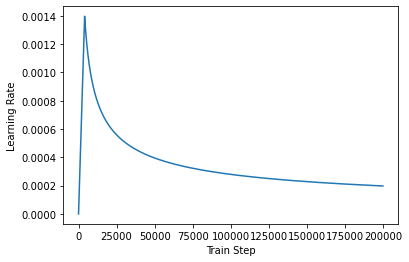

In [88]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Model Compile

In [89]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [90]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
1/1 [==============================] - 0s 2ms/step - loss: 0.9189 - accuracy: 0.0000e+00
Epoch 2/20
1/1 [==============================] - 0s 832us/step - loss: 0.9198 - accuracy: 0.0000e+00
Epoch 3/20
1/1 [==============================] - 0s 787us/step - loss: 0.9105 - accuracy: 0.0000e+00
Epoch 4/20
1/1 [==============================] - 0s 690us/step - loss: 0.9103 - accuracy: 0.0000e+00
Epoch 5/20
1/1 [==============================] - 0s 744us/step - loss: 0.9134 - accuracy: 0.0000e+00
Epoch 6/20
1/1 [==============================] - 0s 840us/step - loss: 0.9233 - accuracy: 0.0000e+00
Epoch 7/20
1/1 [==============================] - 0s 664us/step - loss: 0.9294 - accuracy: 0.0000e+00
Epoch 8/20
1/1 [==============================] - 0s 760us/step - loss: 0.9151 - accuracy: 0.0000e+00
Epoch 9/20
1/1 [==============================] - 0s 1ms/step - loss: 0.9095 - accuracy: 0.0000e+00
Epoch 10/20
1/1 [==============================] - 0s 944us/step - loss: 0.9140 - accu

## Step 5. 모델 평가하기

In [91]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞 뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없으므로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [92]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


임의의 문장으로부터 챗봇의 대답을 얻어봅시다.

....??

In [94]:
sentence_generation('오늘 날씨 어때?')

입력 : 오늘 날씨 어때?
출력 : 할래할래할래할래휘휘휘휘휘휘휘휘휘휘휘휘휘휘크 휘크 휘휘휘휘휘휘V쁜원동력휘그렇다면 는다하 하 하 하 는다할래휘그렇다면 는다할래할래할래할래할래했기했기했기


'할래할래할래할래휘휘휘휘휘휘휘휘휘휘휘휘휘휘크 휘크 휘휘휘휘휘휘V쁜원동력휘그렇다면 는다하 하 하 하 는다할래휘그렇다면 는다할래할래할래할래할래했기했기했기'

In [95]:
sentence_generation('이 드라마 재밌어')

입력 : 이 드라마 재밌어
출력 : 할래할래할래할래휘휘휘휘휘휘휘휘휘휘휘휘휘휘휘크 휘할래할래할래휘휘휘휘할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래


'할래할래할래할래휘휘휘휘휘휘휘휘휘휘휘휘휘휘휘크 휘할래할래할래휘휘휘휘할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래할래'